<a href="https://colab.research.google.com/github/sriharisivashanmugam/BlowerFault/blob/main/Blower_Fault_v2_4_Jan_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stratergy:
 - For each hex, if if had blower fault, get stats of 1 week before fault
 - else get latest 1 week stats
 - Supervised model

In [147]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

In [294]:
def had_fault(data):
  if 'E1.0' in set(data['ErrorCode']):
    return True
  else:
    return False

def number_of_unique_faults(data):
  data['lag_error'] = data['ErrorCode'].shift(1)
  return data[(data['ErrorCode']=='E1.0') & (data['lag_error']!='E1.0')].shape[0]

def get_stats(data,test_data = False):
  if (had_fault(data)==True) and (test_data==False):
    data['lag'] = data['ErrorCode'].shift(1)
    end = int(data[(data['ErrorCode']=='E1.0') & (data['lag']!='E1.0')].index[0])
    data = data.iloc[max(0,end-14400):end+1,:]
  else:
    end = int(max(data.index))
    # data = data.iloc[max(0,end-5040),:]
  mean_pwm = data['BlowerPWM'].mean()
  mean_rpm = data['BlowerRPM'].mean()
  mean_fr = data['FiringRate'].mean()
  mean_ft = data['FlueTemperature'].mean()
  max_pwm = data['BlowerPWM'].max()
  max_rpm = data['BlowerRPM'].max()
  max_fr = data['FiringRate'].max()
  max_ft = data['FlueTemperature'].max()

  return mean_pwm,mean_rpm,mean_fr,mean_ft,max_pwm,max_rpm,max_fr,max_ft

def get_agg(data):
  pass

def prepare_data_frame(path,test_data=False):
  di = {'HEX':[],'mean_pwm':[],'mean_rpm':[],'mean_fr':[],'max_pwm':[],'max_rpm':[],'max_fr':[],'had_fault':[]}
  for i in os.listdir(path):
    temp = pd.read_csv(path+i)
    di['HEX'].append(i.split('.')[0])
    if test_data==False:
      res = get_stats(temp)
    else:
      res = get_stats(temp,True)
    di['mean_pwm'].append(res[0])
    di['mean_rpm'].append(res[1])
    di['mean_fr'].append(res[2])
    # di['mean_ft'].append(res[3])
    di['max_pwm'].append(res[4])
    di['max_rpm'].append(res[5])
    di['max_fr'].append(res[6])
    # di['max_ft'].append(res[7])
    di['had_fault'].append(had_fault(temp))
  df = pd.DataFrame(di)
  return df


In [295]:
new_df = prepare_data_frame('/content/drive/MyDrive/Predictive Models/Blower Fault Phase 2/Hex_with_blowerFault-training/Hex_with_blowerFault/')

In [296]:
new_df = new_df[new_df['max_rpm']>0]

In [297]:
new_df.describe()

,mean_pwm,mean_rpm,mean_fr,max_pwm,max_rpm,max_fr
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,229.264158,6172.592940,13.539090,335.820513,8077.615385,172.717949
std,71.309050,1310.866683,11.928190,68.469306,1084.979714,76.894647
min,82.822096,3232.777446,0.000000,130.000000,4683.000000,0.000000
25%,185.912105,5106.247533,3.498661,332.500000,8072.500000,124.500000
50%,237.119023,6162.978292,14.564728,352.000000,8333.000000,182.000000
75%,279.195772,7161.532519,19.834595,364.500000,8443.500000,251.000000
max,351.344907,8278.469065,53.003680,450.000000,9425.000000,251.000000


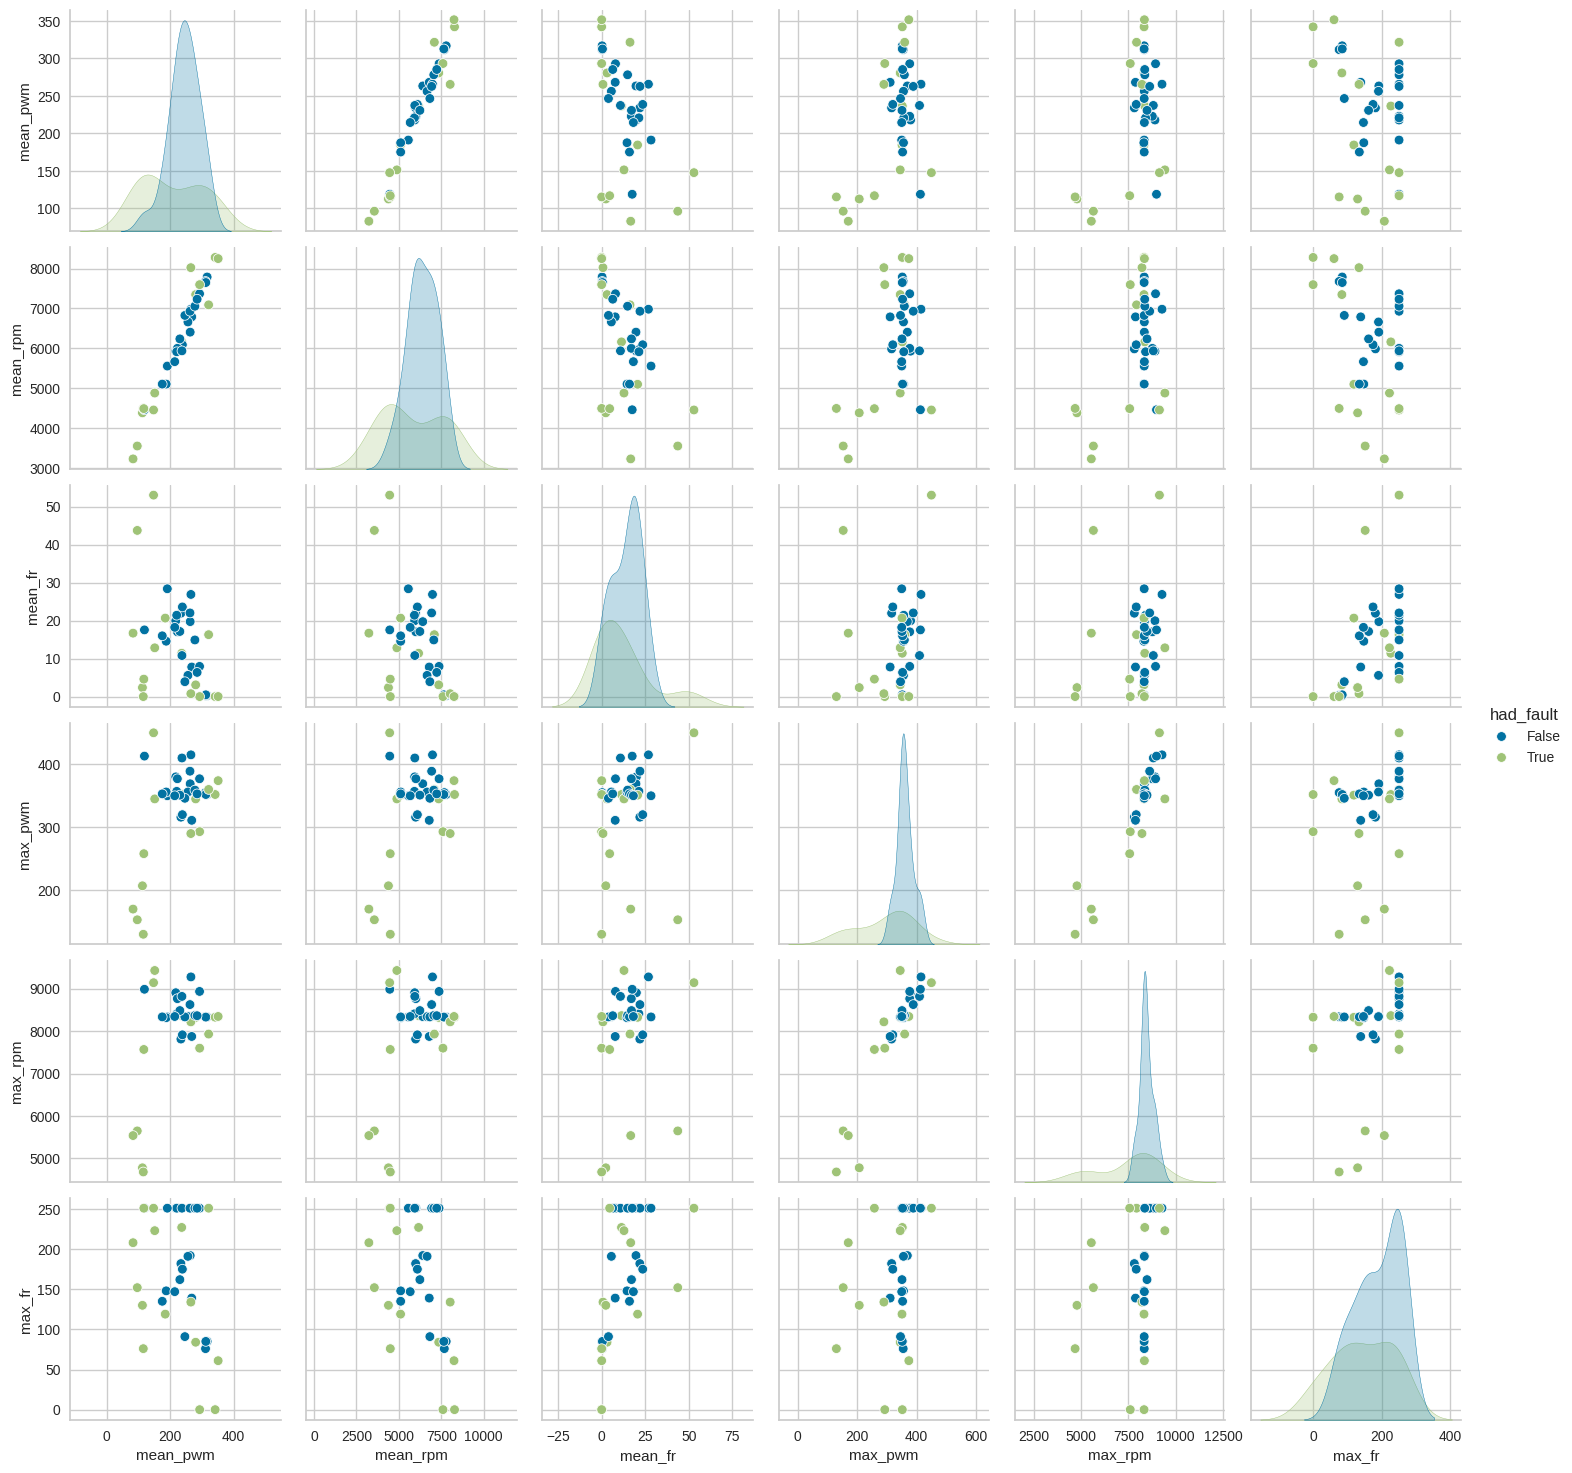

In [298]:
sns.pairplot(new_df,hue='had_fault')

In [299]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X = new_df.iloc[:,1:-1]
Y = new_df.iloc[:,-1]
X = pd.DataFrame(ss.fit_transform(X))
final_df = pd.concat([X,Y],axis=1)

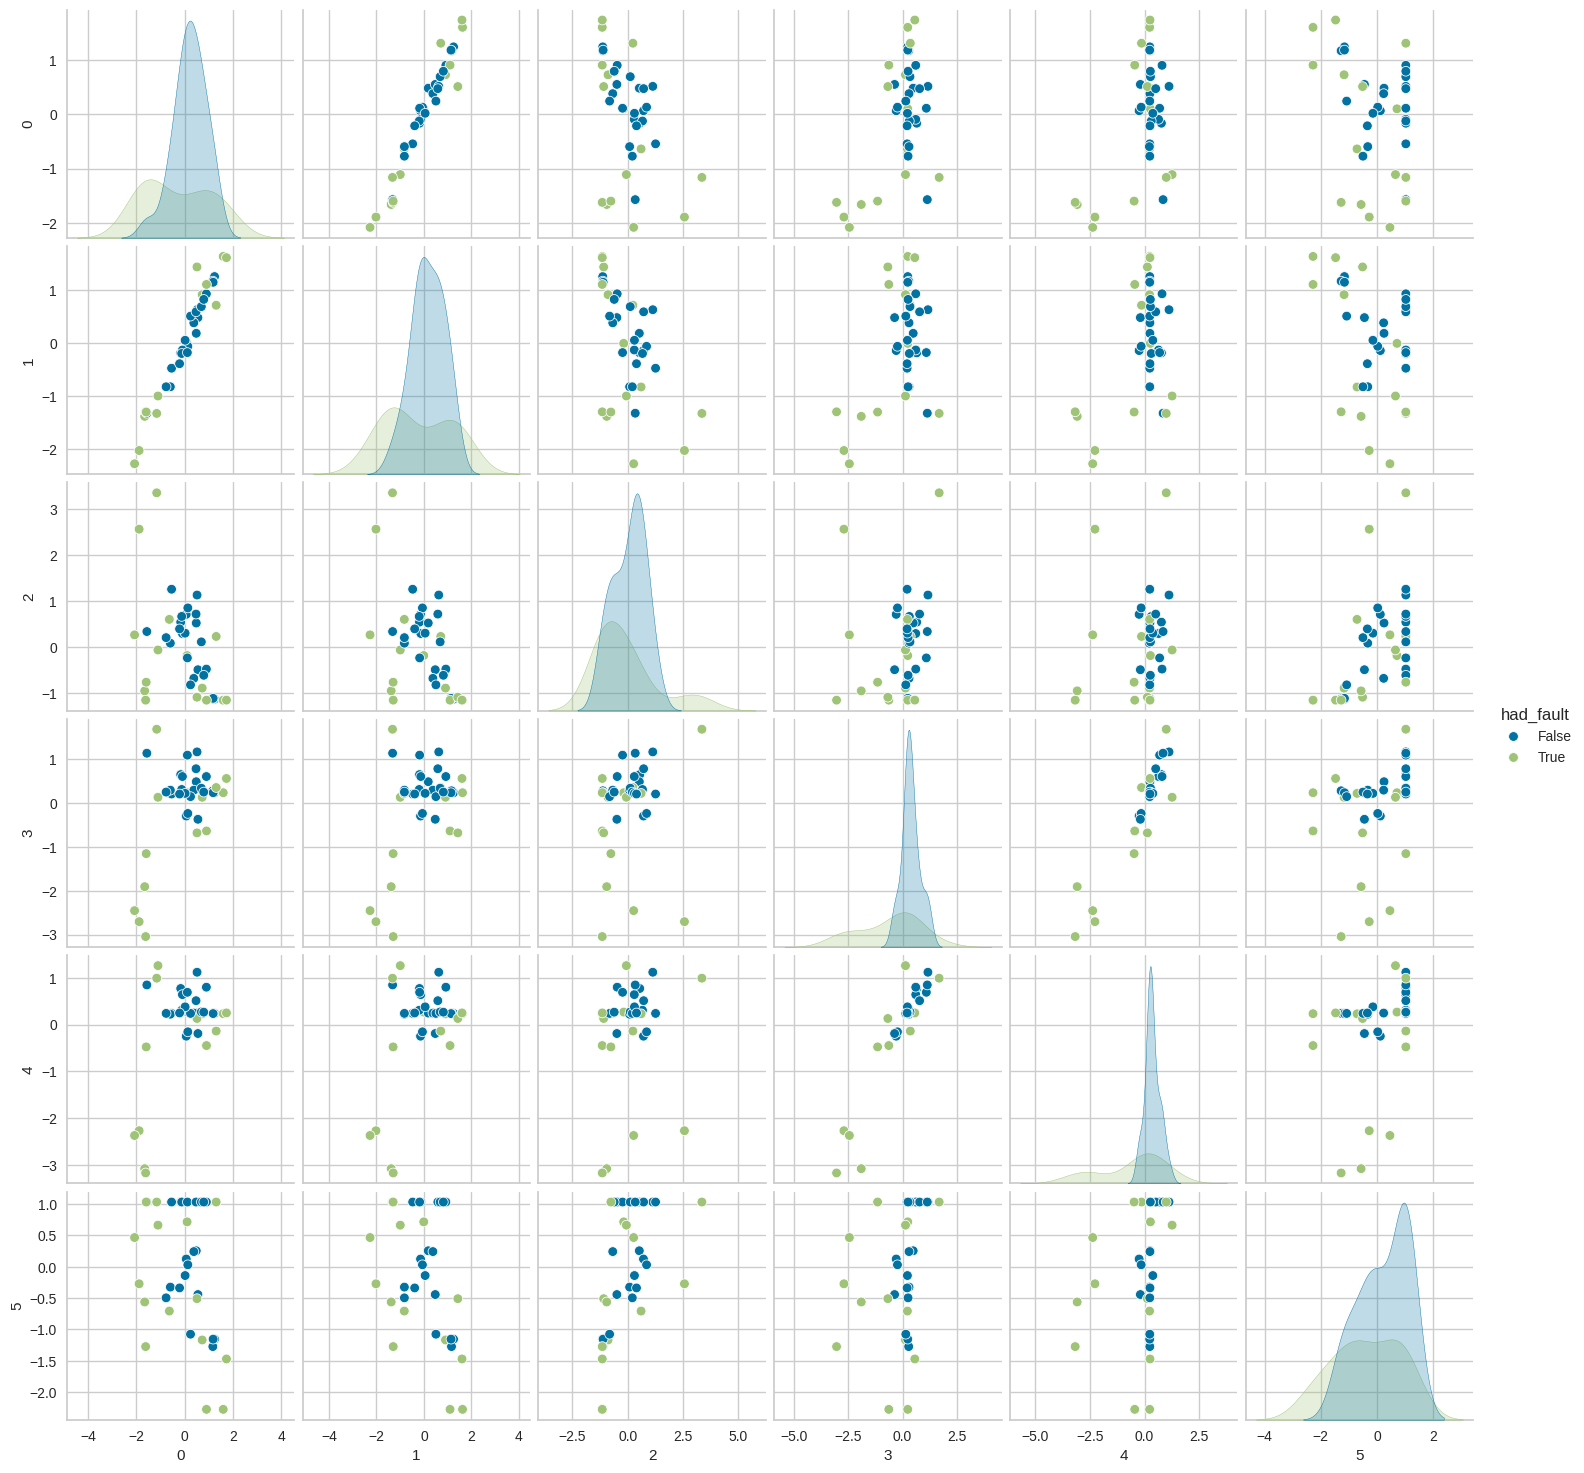

In [300]:
sns.pairplot(final_df,hue='had_fault')

In [301]:
# pip install pycaret

In [302]:
from pycaret.classification import *
s = setup(new_df, target = 'had_fault', session_id = 124)

,Description,Value
0,Session id,124
1,Target,had_fault
2,Target type,Binary
3,Original data shape,"(39, 8)"
4,Transformed data shape,"(39, 8)"
5,Transformed train set shape,"(27, 8)"
6,Transformed test set shape,"(12, 8)"
7,Numeric features,6
8,Categorical features,1
9,Preprocess,True


In [303]:
best = compare_models(sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.7667,0.8000,0.6000,0.5000,0.5333,0.4400,0.4500,0.0650
et,Extra Trees Classifier,0.7333,0.5750,0.3000,0.3000,0.3000,0.3000,0.3000,0.3750
knn,K Neighbors Classifier,0.7000,0.6500,0.3000,0.3000,0.3000,0.2000,0.2000,0.1190
ridge,Ridge Classifier,0.6833,0.0000,0.4000,0.3500,0.3667,0.2400,0.2500,0.0660
rf,Random Forest Classifier,0.6333,0.5250,0.2000,0.2000,0.2000,0.1000,0.1000,0.4100
lr,Logistic Regression,0.6167,0.5000,0.4000,0.3500,0.3667,0.1400,0.1500,0.7950
dt,Decision Tree Classifier,0.6167,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0650
qda,Quadratic Discriminant Analysis,0.6167,0.3500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0670
ada,Ada Boost Classifier,0.6167,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0700
gbc,Gradient Boosting Classifier,0.6167,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1110


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

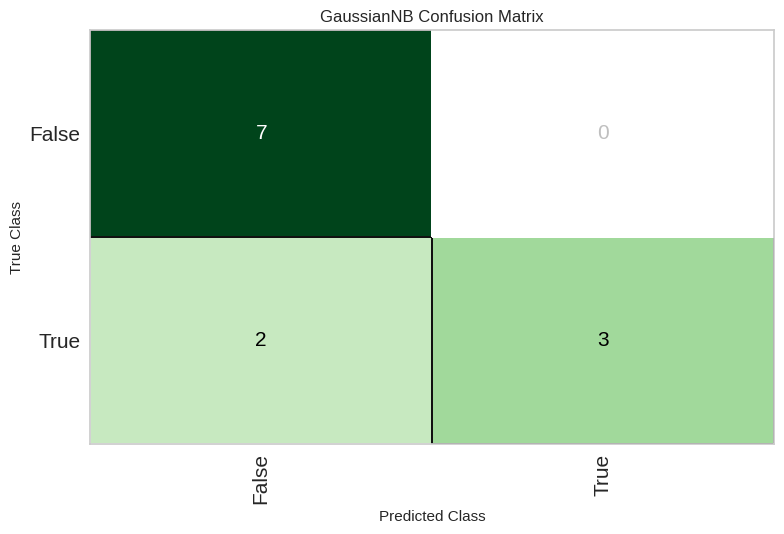

In [304]:
plot_model(best, plot = 'confusion_matrix')

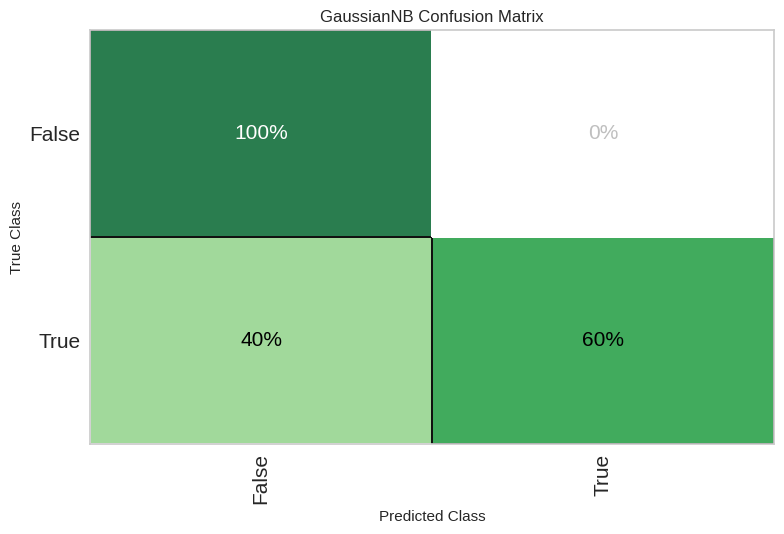

In [305]:
plot_model(best, plot = 'confusion_matrix',plot_kwargs={'percent':True})

In [306]:
predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.8333,0.8286,0.6000,1.0000,0.7500,0.6364,0.6831


,HEX,mean_pwm,mean_rpm,mean_fr,max_pwm,max_rpm,max_fr,had_fault,prediction_label,prediction_score
0,iQ100101051864_HEX_2,217.699753,5931.267578,19.950262,380.0,8902.0,251.0,False,0,0.9994
14,iQ100108151811_HEX_4,184.426987,5101.189453,20.652315,351.0,8323.0,119.0,True,0,0.9905
12,iQ100101021861_HEX_2,311.535675,7677.162109,0.312362,355.0,8335.0,76.0,False,0,0.8511
30,iQ100104051807_HEX_3,112.443787,4386.111816,2.367266,207.0,4781.0,130.0,True,1,1.0000
9,iQ100101021861_HEX_4,316.604889,7788.624512,0.254323,352.0,8332.0,85.0,False,0,0.8447
3,iQ100104202108_HEX_3,233.843643,5987.605469,21.930490,316.0,7811.0,182.0,False,0,0.9771
18,iQ100109201840_HEX_1,341.891327,8278.468750,0.000000,352.0,8326.0,0.0,True,1,0.9711
22,iQ100101021861_HEX_1,246.370697,6826.199707,3.914342,346.0,8332.0,91.0,False,0,0.9866
26,iQ100106071844_HEX_4,262.488770,6930.581543,22.007021,389.0,8623.0,251.0,False,0,0.9995
37,iQ100106081845_HEX_3,214.345825,5667.795410,18.219557,350.0,8342.0,147.0,False,0,0.9985


In [307]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Testing the model

In [308]:
test_df = prepare_data_frame('/content/drive/MyDrive/Predictive Models/Blower Fault Phase 2/Hex_with_blowerFault/',True)

In [309]:
test_df = test_df[~test_df['HEX'].isin(new_df['HEX'])]

In [231]:
x = test_df.iloc[:,1:-1]
y = test_df.iloc[:,-1]

x = pd.DataFrame(ss.transform(x))

test_df = pd.concat([x,y],axis=1)

In [310]:
test_df.dropna(inplace=True)

In [311]:
predictions = predict_model(best, data=test_df, raw_score=True)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.5833,0.6559,0.7059,0.4898,0.5783,0.1923,0.2050


,HEX,mean_pwm,mean_rpm,mean_fr,max_pwm,max_rpm,max_fr,had_fault,prediction_label,prediction_score_0,prediction_score_1
0,iQ100110241866_HEX_1,149.373520,4469.896973,18.121126,450.0,9315.0,251.0,False,1,0.2458,0.7542
1,iQ100110241866_HEX_2,170.410034,5030.215332,26.921366,450.0,9270.0,254.0,True,1,0.4297,0.5703
3,iQ100110241866_HEX_4,157.188202,4627.497070,33.909840,450.0,9314.0,254.0,True,1,0.0442,0.9558
16,iQ100106071844_HEX_1,282.043274,7035.493652,19.955294,367.0,8342.0,251.0,True,0,0.9995,0.0005
20,iQ100106081845_HEX_1,217.041656,5872.157715,25.329458,350.0,8345.0,196.0,True,0,0.9988,0.0012


In [312]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(predictions['had_fault'],predictions['prediction_label']))

[[25 25]
 [10 24]]
